In [1]:
%cd ..

/home/antonbabenko/Projects/newsclass01


In [2]:
%load_ext autoreload
%autoreload 2
%aimport src.model
%aimport src.data
%aimport src.train
%aimport src.eval
%aimport src.utils
%aimport src.metrics

In [3]:
import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from transformers import AutoTokenizer, AdamW, get_linear_schedule_with_warmup

from src.utils import set_seed, load_splits, get_tensorboard_writer
from src.data import TextClassificationDataset
from src.model import TextClassifier
from src.train import fit
from src.eval import eval_nlp
from src.metrics import f1_macro

In [4]:
SEED = 42
MAX_SEQ_LEN = 512
BATCH_SIZE = 64
# MODEL_NAME = "youscan/ukr-roberta-base"
MODEL_NAME = "xlm-roberta-base"
EPOCHS = 8

In [5]:
set_seed(SEED)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
logs_dir = Path("logs") 
states_dir = Path("states") / "nlp" 
states_dir = Path("/media/antonbabenko/hard/news/states") / "nlp"
data_dir = Path("data")
folds = Path("folds") / "nlp"
submissions = Path("submissions") / "nlp"

In [8]:
test_df_path = data_dir / "test_without_target.csv"

In [9]:
test_df = pd.read_csv(test_df_path)

In [10]:
splits = load_splits(folds, val_folds=[2], train_folds=[0, 1, 3, 4]) 

In [11]:
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

Loading tokenizer...


In [12]:
tokenizer.sep_token

'</s>'

In [13]:
splits["test"].empty

True

In [14]:
lengths = []
tokens = []

print('Tokenizing text...')

for sen in splits["train"]["text"]:
    encoded_sent = tokenizer.encode(
        sen,                      # Sentence to encode.
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#         max_length = 512,          # Truncate all sentences.                        
#         return_tensors = 'pt',     # Return pytorch tensors.
   )

    lengths.append(len(encoded_sent))
    tokens.append(encoded_sent)

print('DONE.')

Token indices sequence length is longer than the specified maximum sequence length for this model (867 > 512). Running this sequence through the model will result in indexing errors


Tokenizing text...
DONE.


In [15]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

   Min length: 15 tokens
   Max length: 14,636 tokens
Median length: 410.0 tokens


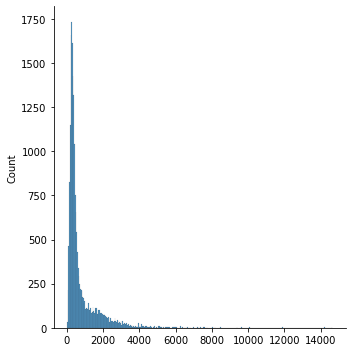

In [16]:
sns.displot(lengths)

Text(-2.450000000000003, 0.5, '# of Text')

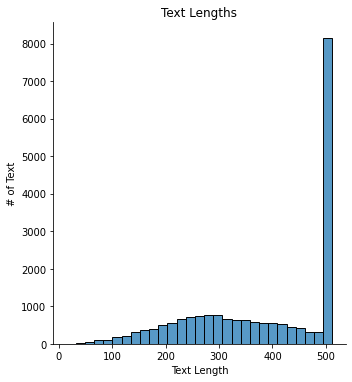

In [17]:
# Truncate any comment lengths greater than 512.
lengths = [min(l, MAX_SEQ_LEN) for l in lengths]

# Plot the distribution of comment lengths.
sns.displot(lengths, kde=False, rug=False)

# Alternatively, you might try using a log scale on the x-axis, but this is 
# tricky. See here for one approach:
# https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
#plt.xscale('log')

plt.title('Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('# of Text')

In [18]:
# Count the number of sentences that had to be truncated to 512 tokens.
num_truncated = lengths.count(MAX_SEQ_LEN)

# Compare this to the total number of training sentences.
num_sentences = len(lengths)
prcnt = float(num_truncated) / float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than {} tokens.'.format(num_truncated, num_sentences, prcnt, MAX_SEQ_LEN))

7,868 of 20,293 sentences (38.8%) in the training set are longer than 512 tokens.


In [ ]:
train_dataset = TextClassificationDataset(
    df=splits["train"],
    tokenizer=tokenizer,
    mode="train",
    max_seq_length=MAX_SEQ_LEN
)

valid_dataset = TextClassificationDataset(
    df=splits["val"],
    tokenizer=tokenizer,
    mode="val",
    max_seq_length=MAX_SEQ_LEN
)

test_dataset = TextClassificationDataset(
    df=test_df,
    tokenizer=tokenizer,
    mode="test",
    max_seq_length=MAX_SEQ_LEN
)

In [ ]:
# train_dataset = Subset(train_dataset, list(range(16)))
# valid_dataset = Subset(valid_dataset, list(range(16)))
# test_dataset = Subset(test_dataset, 20)

In [ ]:
train_data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_data_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_data_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [ ]:
dataloaders = {
    "train": train_data_loader,
    "val": val_data_loader,
    "test": test_data_loader
}

In [ ]:
mini_batch_data = next(iter(val_data_loader))
mini_batch_data.keys()

In [ ]:
print(mini_batch_data['input_ids'].shape)
print(mini_batch_data['attention_mask'].shape)
print(mini_batch_data['targets'].shape)

In [ ]:
tokenizer.decode(mini_batch_data['input_ids'][0])

### Model Setup

In [27]:
model = TextClassifier(
    n_classes=splits["train"]["source"].unique().shape[0],
    pretrained_model_name=MODEL_NAME,
    dropout=0.4
).to(device)

### Metrics

In [28]:
metrics = {
    "f1_macro": f1_macro
}

### Tensorboard setup

In [29]:
model_name = f"xlm-roberta-base-title-{int(datetime.datetime.now().timestamp())}"
writer = get_tensorboard_writer(logs_dir, model_name) 

In [30]:
optimizer = AdamW([
    {"params": model.bert.parameters(), "lr": 2e-6},
    {"params": model.out.parameters(), "lr": 2e-3}], 
    correct_bias=False
)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)
criterion = nn.CrossEntropyLoss().to(device)

In [31]:
fit(
    model,
    criterion,
    optimizer,
    dataloaders,
    device,
    scheduler=scheduler,
    metrics=metrics,
    epochs=EPOCHS,
    model_name=model_name,
    model_folder=states_dir,
    writer=writer
)

Epoch: 1/8, validation phase: 100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


{'f1_macro': 0.394707656285295}
Epoch: 1/8, time: 145.3797149658203 train loss: 1.6102171202746407, val loss: 1.1521792563311573


Epoch: 2/8, train phase:   0%|          | 0/318 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 2/8, validation phase: 100%|██████████| 80/80 [00:10<00:00,  7.82it/s]


{'f1_macro': 0.4298801625734492}
Epoch: 2/8, time: 141.58298468589783 train loss: 1.1807849937361046, val loss: 1.0107506136588862


Epoch: 3/8, train phase:   0%|          | 0/318 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 3/8, validation phase: 100%|██████████| 80/80 [00:10<00:00,  7.78it/s]


{'f1_macro': 0.4462308664882455}
Epoch: 3/8, time: 141.64145350456238 train loss: 1.0576962948679625, val loss: 0.9660305024837625


Epoch: 4/8, train phase:   0%|          | 0/318 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 4/8, validation phase: 100%|██████████| 80/80 [00:10<00:00,  7.83it/s]


{'f1_macro': 0.45322378393497464}
Epoch: 4/8, time: 141.61314582824707 train loss: 0.9856315923819187, val loss: 0.9481701332125171


Epoch: 5/8, train phase:   0%|          | 0/318 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 5/8, validation phase: 100%|██████████| 80/80 [00:10<00:00,  7.76it/s]


{'f1_macro': 0.4554658406919099}
Epoch: 5/8, time: 142.10412073135376 train loss: 0.9411767890358995, val loss: 0.9536448428431168


Epoch: 6/8, train phase:   0%|          | 0/318 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 6/8, validation phase: 100%|██████████| 80/80 [00:10<00:00,  7.79it/s]


{'f1_macro': 0.46704377377255524}
Epoch: 6/8, time: 142.16944122314453 train loss: 0.907019407201799, val loss: 0.9408403046730117


Epoch: 7/8, train phase:   0%|          | 0/318 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 7/8, validation phase: 100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


{'f1_macro': 0.46789807140139306}
Epoch: 7/8, time: 142.1951265335083 train loss: 0.8959412703094431, val loss: 0.9274874422820331


Epoch: 8/8, train phase:   0%|          | 0/318 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 8/8, validation phase: 100%|██████████| 80/80 [00:10<00:00,  7.83it/s]


{'f1_macro': 0.4699196625042602}
Epoch: 8/8, time: 142.09409165382385 train loss: 0.8755619127213594, val loss: 0.9252029899540793
Checkpoint was saved


## Evaluation

In [ ]:
checkpoint_path = states_dir / "epoch-14-youscan-ukr-roberta-base-1616447037-checkpoint.pt"

In [ ]:
model = TextClassifier(
    n_classes=splits["train"]["source"].unique().shape[0],
    pretrained_model_name=MODEL_NAME,
    dropout=0.4
)

In [ ]:
checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
model.load_state_dict(checkpoint["model_state_dict"])
print("Models have been loaded")

model = model.to(device)

In [ ]:
predictions, _ = eval_nlp(model, dataloaders["test"], device)

In [ ]:
test_df["Predicted"] = predictions

In [ ]:
submission_df = test_df[["Id", "Predicted"]]

In [ ]:
submission_df.to_csv(submissions / f"youscan-roberta-{int(datetime.datetime.now().timestamp())}.csv", index=False)